In [1]:
import numpy as np
# affine変換
def affine(z, W, b):
    return np.dot(z, W) + b
# affine変換勾配
def affine_back(du, z, W, b):
    dz = np.dot(du, W.T)
    dW = np.dot(z.T, du)
    db = np.dot(np.ones(z.shape[0]).T, du)
    return dz, dW, db
# 活性化関数(ReLU)
def relu(u):
    return np.maximum(0, u)
# 活性化関数(ReLU)勾配
def relu_back(dz, u):
    return dz * np.where(u > 0, 1, 0)
# 活性化関数(softmax)
def softmax(u):
    max_u = np.max(u, axis=1, keepdims=True)
    exp_u = np.exp(u-max_u)
    return exp_u/np.sum(exp_u, axis=1, keepdims=True)
# 誤差(交差エントロピー）
def cross_entropy_error(y, t):
    return -np.sum(t * np.log(np.maximum(y,1e-7)))/y.shape[0]
# 誤差(交差エントロピー）＋活性化関数(softmax)勾配
def softmax_cross_entropy_error_back(y, t):
    return (y - t)/y.shape[0]

In [2]:
def learn(x, t, W1, b1, W2, b2, W3, b3, lr):
    # 順伝播
    u1 = affine(x, W1, b1)
    z1 = relu(u1)
    u2 = affine(z1, W2, b2)
    z2 = relu(u2)
    u3 = affine(z2, W3, b3)
    y  = softmax(u3)
    # 逆伝播
    dy = softmax_cross_entropy_error_back(y, t)
    dz2, dW3, db3 = affine_back(dy, z2, W3, b3)
    du2 = relu_back(dz2, u2)
    dz1, dW2, db2 = affine_back(du2, z1, W2, b2)
    du1 = relu_back(dz1, u1)
    dx, dW1, db1 = affine_back(du1, x, W1, b1)
    # 重み、バイアスの更新
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    W3 = W3 - lr * dW3
    b3 = b3 - lr * db3

    return W1, b1, W2, b2, W3, b3

In [3]:
def predict(x, W1, b1, W2, b2, W3, b3):
    # 順伝播
    u1 = affine(x, W1, b1)
    z1 = relu(u1)
    u2 = affine(z1, W2, b2)
    z2 = relu(u2)
    u3 = affine(z2, W3, b3)
    y  = softmax(u3)
    return y

In [4]:
import gzip
import numpy as np
# MNIST読み込み
def load_mnist( mnist_path ) :
    return _load_image(mnist_path + 'train-images-idx3-ubyte.gz'), \
           _load_label(mnist_path + 'train-labels-idx1-ubyte.gz'), \
           _load_image(mnist_path + 't10k-images-idx3-ubyte.gz'), \
           _load_label(mnist_path + 't10k-labels-idx1-ubyte.gz')
def _load_image( image_path ) :
    # 画像データの読み込み
    with gzip.open(image_path, 'rb') as f:
        buffer = f.read()
    size = np.frombuffer(buffer, np.dtype('>i4'), 1, offset=4)
    rows = np.frombuffer(buffer, np.dtype('>i4'), 1, offset=8)
    columns = np.frombuffer(buffer, np.dtype('>i4'), 1, offset=12)
    data = np.frombuffer(buffer, np.uint8, offset=16)
    image = np.reshape(data, (size[0], rows[0]*columns[0]))
    image = image.astype(np.float32)
    return image
def _load_label( label_path ) :
    # 正解データ読み込み
    with gzip.open(label_path, 'rb') as f:
        buffer = f.read()
    size = np.frombuffer(buffer, np.dtype('>i4'), 1, offset=4)
    data = np.frombuffer(buffer, np.uint8, offset=8)
    label = np.zeros((size[0], 10))
    for i in range(size[0]):
        label[i, data[i]] = 1
    return label

# 正解率
def accuracy_rate(y, t):
    max_y = np.argmax(y, axis=1)
    max_t = np.argmax(t, axis=1)
    return np.sum(max_y == max_t)/y.shape[0]

# MNISTデータ読み込み
x_train, t_train, x_test, t_test = load_mnist('c:\\mnist\\')

# 入力データの正規化(0～1)
nx_train = x_train/255
nx_test  = x_test/255

# ノード数設定
d0 = nx_train.shape[1]
d1 = 100 # 1層目のノード数
d2 = 50  # 2層目のノード数
d3 = 10
# 重みの初期化(-0.1～0.1の乱数)
np.random.seed(8)
W1 = np.random.rand(d0, d1) * 0.2 - 0.1
W2 = np.random.rand(d1, d2) * 0.2 - 0.1
W3 = np.random.rand(d2, d3) * 0.2 - 0.1
# バイアスの初期化(0)
b1 = np.zeros(d1)
b2 = np.zeros(d2)
b3 = np.zeros(d3)

# 学習率
lr = 0.5
# バッチサイズ
batch_size = 100
# 学習回数
epoch = 50

# 予測（学習データ）
y_train = predict(nx_train, W1, b1, W2, b2, W3, b3)
# 予測（テストデータ）
y_test = predict(nx_test, W1, b1, W2, b2, W3, b3)
# 正解率、誤差表示
train_rate, train_err = accuracy_rate(y_train, t_train), cross_entropy_error(y_train, t_train)
test_rate, test_err = accuracy_rate(y_test, t_test), cross_entropy_error(y_test, t_test)
print("{0:3d} train_rate={1:6.2f}% test_rate={2:6.2f}% train_err={3:8.5f} test_err={4:8.5f}".format((0), train_rate*100, test_rate*100, train_err, test_err))

for i in range(epoch):
    # 学習
    for j in range(0, nx_train.shape[0], batch_size):
        W1, b1, W2, b2, W3, b3 = learn(nx_train[j:j+batch_size], t_train[j:j+batch_size], W1, b1, W2, b2, W3, b3, lr)

    # 予測（学習データ）
    y_train = predict(nx_train, W1, b1, W2, b2, W3, b3)
    # 予測（テストデータ）
    y_test = predict(nx_test, W1, b1, W2, b2, W3, b3)
    # 正解率、誤差表示
    train_rate, train_err = accuracy_rate(y_train, t_train), cross_entropy_error(y_train, t_train)
    test_rate, test_err = accuracy_rate(y_test, t_test), cross_entropy_error(y_test, t_test)
    print("{0:3d} train_rate={1:6.2f}% test_rate={2:6.2f}% train_err={3:8.5f} test_err={4:8.5f}".format((i+1), train_rate*100, test_rate*100, train_err, test_err))

  0 train_rate= 11.67% test_rate= 12.18% train_err= 2.30623 test_err= 2.30601
  1 train_rate= 92.39% test_rate= 92.38% train_err= 0.24541 test_err= 0.24307
  2 train_rate= 96.78% test_rate= 96.34% train_err= 0.10314 test_err= 0.11774
  3 train_rate= 97.67% test_rate= 97.02% train_err= 0.07395 test_err= 0.10026
  4 train_rate= 98.03% test_rate= 97.06% train_err= 0.06057 test_err= 0.09716
  5 train_rate= 98.34% test_rate= 97.18% train_err= 0.05275 test_err= 0.09951
  6 train_rate= 98.65% test_rate= 97.30% train_err= 0.04209 test_err= 0.09596
  7 train_rate= 98.51% test_rate= 96.95% train_err= 0.04488 test_err= 0.10893
  8 train_rate= 98.79% test_rate= 97.39% train_err= 0.03560 test_err= 0.09737
  9 train_rate= 99.01% test_rate= 97.47% train_err= 0.03033 test_err= 0.09725
 10 train_rate= 99.12% test_rate= 97.57% train_err= 0.02574 test_err= 0.09797
 11 train_rate= 99.16% test_rate= 97.47% train_err= 0.02525 test_err= 0.10192
 12 train_rate= 99.38% test_rate= 97.67% train_err= 0.01840 test

  0 正解=7 予測=7 予測確率=100.00%


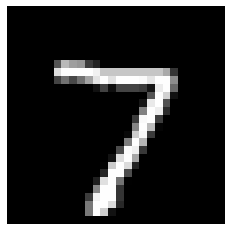

  1 正解=2 予測=2 予測確率=100.00%


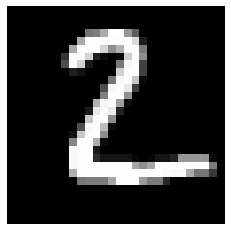

  2 正解=1 予測=1 予測確率=100.00%


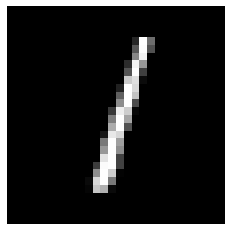

  3 正解=0 予測=0 予測確率=100.00%


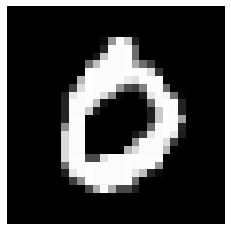

  4 正解=4 予測=4 予測確率=100.00%


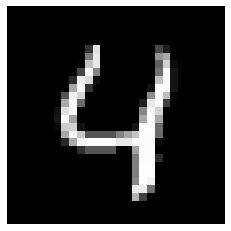

  5 正解=1 予測=1 予測確率=100.00%


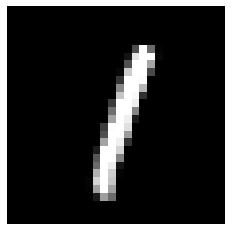

  6 正解=4 予測=4 予測確率=100.00%


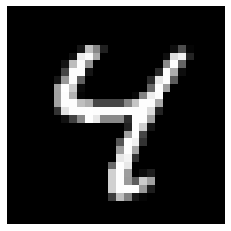

  7 正解=9 予測=9 予測確率=100.00%


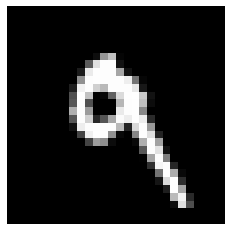

  8 正解=5 予測=5 予測確率=100.00%


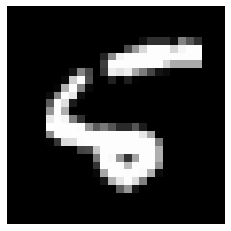

  9 正解=9 予測=9 予測確率=100.00%


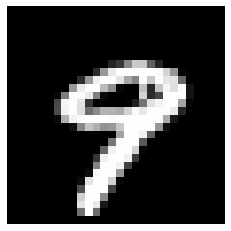

In [5]:
# 本当に正解しているかどうかの確認方法です。以下は、テストデータの10件目までの正解、予測値、予測した確率を表示します。
import matplotlib.pyplot as plt
data = np.reshape(x_test, (10000,28,28))
for i in range(10):
        print("{0:3d} 正解={1} 予測={2} 予測確率={3:6.2f}%".format(i, np.argmax(t_test[i]), np.argmax(y_test[i]), np.max(y_test[i])*100))
        plt.imshow(data[i], 'gray')
        plt.axis('off')
        plt.show()

104 正解=9 予測=5 予測確率= 93.15%


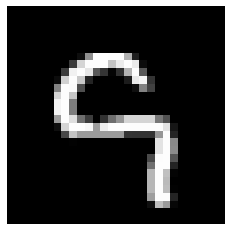

115 正解=4 予測=9 予測確率= 96.87%


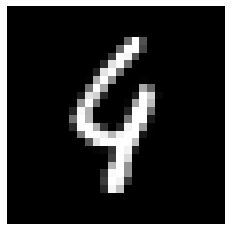

151 正解=9 予測=8 予測確率= 94.78%


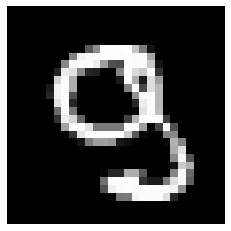

217 正解=6 予測=5 予測確率= 95.10%


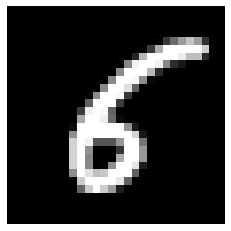

247 正解=4 予測=2 予測確率=100.00%


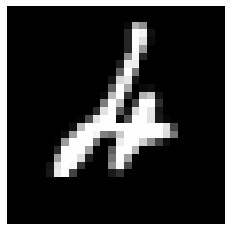

340 正解=5 予測=3 予測確率=100.00%


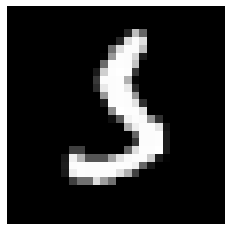

381 正解=3 予測=7 予測確率= 99.95%


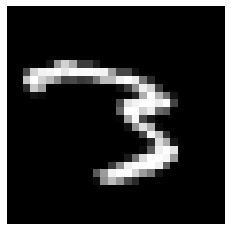

445 正解=6 予測=0 予測確率= 99.92%


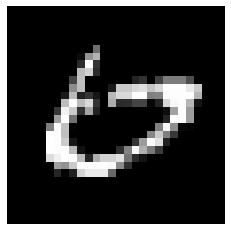

582 正解=8 予測=2 予測確率= 98.13%


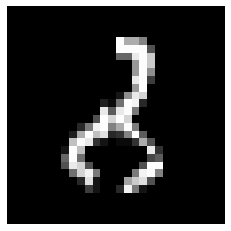

583 正解=2 予測=7 予測確率= 98.36%


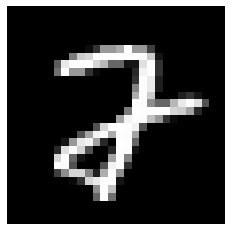

659 正解=2 予測=7 予測確率= 72.95%


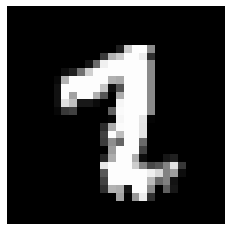

720 正解=5 予測=8 予測確率=100.00%


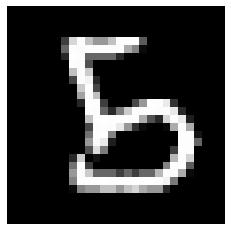

883 正解=3 予測=5 予測確率= 92.00%


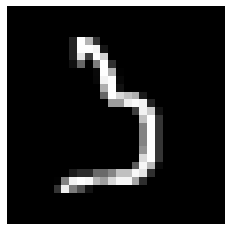

900 正解=1 予測=3 予測確率= 96.92%


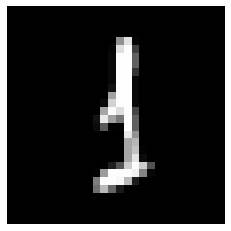

947 正解=8 予測=9 予測確率= 69.23%


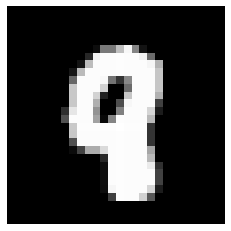

951 正解=5 予測=4 予測確率= 99.95%


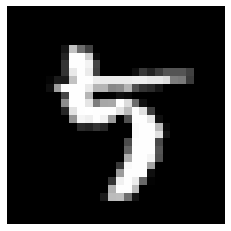

956 正解=1 予測=2 予測確率= 99.99%


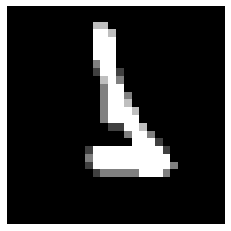

In [6]:
# 不正解のデータの表示は、以下です。1000件目までの不正解のデータを表示しています。
import matplotlib.pyplot as plt
data = np.reshape(x_test, (10000,28,28))
for i in range(1000):
    if np.argmax(y_test[i]) != np.argmax(t_test[i]):
        print("{0:3d} 正解={1} 予測={2} 予測確率={3:6.2f}%".format(i, np.argmax(t_test[i]), np.argmax(y_test[i]), np.max(y_test[i])*100))
        plt.imshow(data[i], 'gray')
        plt.axis('off')
        plt.show()